<a href="https://colab.research.google.com/github/Bishara10/EEG-Classification/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Prerequisites


In [1]:
!git clone https://github.com/BPy5/ML-Classification-model-For-EEG-Recordings.git

fatal: destination path 'ML-Classification-model-For-EEG-Recordings' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.signal import resample, butter, filtfilt
from scipy.stats import pearsonr


%matplotlib notebook
%matplotlib inline

# Preprocess dataset

### Load Data

In [3]:
# File names for patient recordings
file_names_adhd_dataset = ['v8p.csv', 'v35p.csv', 'v37p.csv', 'v36p.csv', 'v38p.csv', 'v6p.csv', 'v40p.csv', 'v39p.csv', 'v3p.csv', 'v29p.csv', 'v30p.csv', 'v31p.csv', 'v28p.csv', 'v279.csv', 'v33p.csv', 'v25p.csv', 'v286.csv', 'v250.csv', 'v24p.csv', 'v246.csv', 'v263.csv', 'v27p.csv', 'v254.csv', 'v284.csv', 'v238.csv', 'v265.csv', 'v227.csv', 'v215.csv', 'v236.csv', 'v22p.csv', 'v21p.csv', 'v231.csv', 'v244.csv', 'v213.csv', 'v274.csv', 'v200.csv', 'v206.csv', 'v19p.csv', 'v173.csv', 'v270.csv', 'v234.csv', 'v179.csv', 'v181.csv', 'v18p.csv', 'v14p.csv', 'v196.csv', 'v209.csv', 'v183.csv', 'v12p.csv', 'v219.csv', 'v15p.csv', 'v20p.csv', 'v198.csv', 'v190.csv', 'v1p.csv', 'v32p.csv', 'v177.csv', 'v10p.csv', 'v34p.csv', 'v288.csv', 'v204.csv']
file_names_control_dataset = ['v51p.csv', 'v59p.csv', 'v304.csv', 'v45p.csv', 'v54p.csv', 'v58p.csv', 'v53p.csv', 'v60p.csv', 'v56p.csv', 'v46p.csv', 'v308.csv', 'v42p.csv', 'v43p.csv', 'v306.csv', 'v48p.csv', 'v50p.csv', 'v52p.csv', 'v302.csv', 'v44p.csv', 'v47p.csv', 'v307.csv', 'v57p.csv', 'v303.csv', 'v127.csv', 'v134.csv', 'v121.csv', 'v299.csv', 'v151.csv', 'v116.csv', 'v125.csv', 'v133.csv', 'v300.csv', 'v147.csv', 'v298.csv', 'v113.csv', 'v118.csv', 'v117.csv', 'v120.csv', 'v111.csv', 'v107.csv', 'v114.csv', 'v108.csv', 'v115.csv', 'v305.csv', 'v140.csv', 'v149.csv', 'v309.csv', 'v123.csv', 'v138.csv', 'v112.csv', 'v41p.csv', 'v129.csv', 'v143.csv', 'v310.csv', 'v131.csv', 'v297.csv', 'v109.csv', 'v49p.csv', 'v55p.csv', 'v110.csv']

# File paths for recordings and output
pathControl = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/'
pathADHD = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/'

### Functions for preprocessing
Downsampling: to redude the number of samples in the given data.
BandPassFilter to filter signal noise.
Preprocess_file: preprocesses a single file.
Preprocess_group: preprocess and save all files to a corresponding group folder.

In [4]:
# Preprocessed dataset lists
dataADHD = []
dataControl = []

# Parameters for bandpass filter
lowcut = 1.0  # Hz
highcut = 40.0  # Hz

# Set parameters
original_fs = 128  # Sampling frequency in Hz
target_fs = 64  # Target sampling frequency in Hz
nperseg = 128  # Number of samples per segment
noverlap = 64  # Number of overlapping samples (typically half of nperseg)


In [5]:
# Bandpass filter: filter channel and reduce noise.
def bandPassFilter(signal):
    fs = 4000.0

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 2
    b, a = butter(order, [low, high], 'bandpass', analog=False)
    y = filtfilt(b, a, signal, axis=0)

    return y

In [6]:
# Compute Pearson correlation features between 2 signals
def pearson_correlation_two_signals(signal1, signal2):
  statistic, pvalue = pearsonr(signal1, signal2)

  return statistic, pvalue

In [7]:
# Function for downsampling the signal
def downsample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

In [8]:
# Function for preprocessing an entire recording for a single patient
def preprocess_file(input_file, group_category):
  df = pd.read_csv(input_file) # Read recording
  new_signals = []  # new signals list
  pearson_cors = []  # pearson correlations list of every 2 signals

  # Loop through all channels (columns in the recording)
  for column in df.columns:
    # get channel recordings
    signal = df[column].values

    # Preprocess by downsampling, then filter channel using bandpass filter
    downsampled_signal = downsample_signal(signal, original_fs, target_fs)
    filtered_signal = bandPassFilter(downsampled_signal)

    # append processed signal to new_signals list
    new_signals.append(filtered_signal)

  # for every pair of signals, extract the pearson correlation value
  for signal in range(len(new_signals) - 1):
    for next_signal in range(len(new_signals)):
      corr, _ = pearson_correlation_two_signals(new_signals[signal], new_signals[next_signal])
      pearson_cors.append(corr)

  # Add processed recording to its corresponding group
  if group_category == 'ADHD':
    dataADHD.append(pearson_cors)
  elif group_category == 'CONTROL':
    dataControl.append(pearson_cors)

In [9]:
# Function for preprocessing all recordings for a specific group
def preprocess_group(group_path, group_file_names, group_category):
  i = 1
  for filename in group_file_names:
    file_name_and_path = group_path + filename;
    print(filename + ' data preprocessed ' + str(i) + '/' + str(len(group_file_names)))
    preprocess_file(file_name_and_path, group_category)
    i += 1
  print("=============================== Preprocessing group " + group_category + " successful =============================== ")

In [10]:
filesADHD = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/' + x for x in file_names_adhd_dataset]
filesControl = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/' + x for x in file_names_control_dataset]

# preprocess all groups (ADHD and Control)
preprocess_group(pathADHD, file_names_adhd_dataset, 'ADHD')
preprocess_group(pathControl, file_names_control_dataset, 'CONTROL')

v8p.csv data preprocessed 1/61
v35p.csv data preprocessed 2/61
v37p.csv data preprocessed 3/61
v36p.csv data preprocessed 4/61
v38p.csv data preprocessed 5/61
v6p.csv data preprocessed 6/61
v40p.csv data preprocessed 7/61
v39p.csv data preprocessed 8/61
v3p.csv data preprocessed 9/61
v29p.csv data preprocessed 10/61
v30p.csv data preprocessed 11/61
v31p.csv data preprocessed 12/61
v28p.csv data preprocessed 13/61
v279.csv data preprocessed 14/61
v33p.csv data preprocessed 15/61
v25p.csv data preprocessed 16/61
v286.csv data preprocessed 17/61
v250.csv data preprocessed 18/61
v24p.csv data preprocessed 19/61
v246.csv data preprocessed 20/61
v263.csv data preprocessed 21/61
v27p.csv data preprocessed 22/61
v254.csv data preprocessed 23/61
v284.csv data preprocessed 24/61
v238.csv data preprocessed 25/61
v265.csv data preprocessed 26/61
v227.csv data preprocessed 27/61
v215.csv data preprocessed 28/61
v236.csv data preprocessed 29/61
v22p.csv data preprocessed 30/61
v21p.csv data preproce

In [11]:
len(dataADHD)

61

In [12]:
len(dataControl)

60

# Classification model: SVM

### Prepare data and make a train-test split

In [13]:
# Convert the lists into numpy arrays
X_adhd = np.array(dataADHD)
X_control = np.array(dataControl)

# Combine ADHD and contol data
X = np.vstack((X_adhd, X_control))

# Create the label vector (1 for ADHD, 0 for control)
y = np.array([1] * len(X_adhd) + [0] * len(X_control))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

### Train SVM model

In [14]:
# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

### Evaluate and plot confusion matrix

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.86      0.86      0.86         7

    accuracy                           0.85        13
   macro avg       0.85      0.85      0.85        13
weighted avg       0.85      0.85      0.85        13



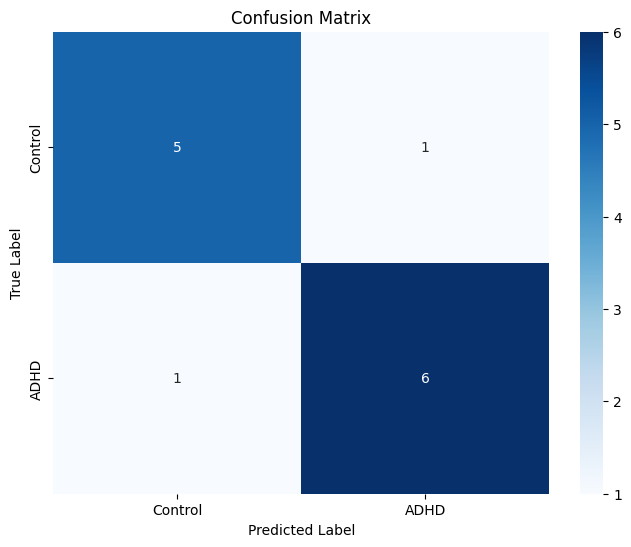

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Make a prediction

In [16]:
data = np.array(dataControl[8]).reshape(1, -1)

pred = svm_model.predict(data)
print(pred)

[0]
